In [1]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

In [2]:
#Create a directory for the figures if it does not already exist.
os.makedirs('./Figures', exist_ok=True)

In [3]:
#Read in the cleaned data generated by Data_Cleaning. Save that data as a pandas dataframe, df.
df = pd.read_csv('./Cleaned_Data/III_Full_Data_wPCA.csv')

#Correcting cycle number. Original author's state that EIS measurements are taken every other cycle. 
#Therefore we should multiply the given cycles by 2 to get the true cycle number.
df["cycle number"] = df["cycle number"].apply(lambda x: 2*x)
df["Cycles Until Fail"] = df["Cycles Until Fail"].apply(lambda x: 2*x)#Correcting cycle number. Original author's state that EIS measurements are taken every other cycle. 

# Adding a classification taget and an additional feature that we can use for regression. 

# Adding a column for the true category (1 if the battery lasts over 200 cycles) (0 otherwise).
to_num=df['label']
to_num=to_num.map({'25C01':1.0,'25C02':0.0,'25C03':0.0,'25C04':0.0,'25C05':0.0,'25C06':0.0,'25C07':0.0,'25C08':0.0,
            '35C01':1.0,'35C02':1.0,'45C01':1.0,'45C02':1.0})
df['category']=to_num

# Adding temperature as a column. 
temdf=df['label']
temdf=temdf.map({'25C01':25.0,'25C02':25.0,'25C03':25.0,'25C04':25.0,'25C05':25.0,'25C06':25.0,'25C07':25.0,
                 '25C08':25.0,'35C01':35.0,'35C02':35.0,'45C01':45.0,'45C02':45.0})
df['temperature']=temdf

df[df['cycle number']==2]

,label,cycle number,Capacity/mA.h,Norm_Cap,Cycles Until Fail,20004.453 Re,15829.126 Re,12516.703 Re,9909.4424 Re,7835.48 Re,...,0.06443 Im,0.05102 Im,0.04042 Im,0.03192 Im,0.02528 Im,0.01999 Im,EIS_PCA_1,EIS_PCA_2,category,temperature
0,25C01,2,37.202713,1.0,234,0.39182,0.39693,0.40190,0.40953,0.41789,...,0.02416,0.11901,0.31792,0.57825,0.80068,0.86385,-0.565900,0.013149,1.0,25.0
261,25C02,2,35.060836,1.0,12,0.27511,0.28172,0.28929,0.29862,0.30913,...,0.06507,0.15825,0.35017,0.59216,0.78456,0.82118,1.129450,-0.764990,0.0,25.0
442,25C03,2,36.771703,1.0,164,0.27156,0.28309,0.29273,0.30313,0.31344,...,0.09070,0.18380,0.36200,0.58192,0.74873,0.77043,1.839922,-0.979062,0.0,25.0
644,25C04,2,35.534219,1.0,114,0.26768,0.27533,0.28455,0.29295,0.30268,...,0.11098,0.04966,0.04945,0.17528,0.45059,0.83157,1.446762,-0.847241,0.0,25.0
679,25C05,2,37.210831,1.0,152,0.35034,0.35724,0.36385,0.37172,0.37715,...,0.04909,0.17230,0.38189,0.61269,0.76343,0.73260,-1.116648,-0.122425,0.0,25.0
955,25C06,2,35.992184,1.0,120,0.29312,0.29999,0.30920,0.31791,0.32990,...,0.13683,0.28203,0.47433,0.63394,0.67345,0.53849,0.689808,-0.537390,0.0,25.0
1168,25C07,2,35.684646,1.0,32,0.30021,0.30771,0.31790,0.32862,0.33804,...,0.34707,0.34835,0.27393,0.13518,-0.01207,-0.06566,1.381021,-0.560084,0.0,25.0
1308,25C08,2,33.943672,1.0,32,0.28968,0.29942,0.30966,0.31813,0.32953,...,0.24107,0.15772,0.05621,-0.00332,0.06764,0.34762,1.763887,-0.741189,0.0,25.0
1345,35C01,2,40.113305,1.0,218,0.29797,0.30586,0.31193,0.31787,0.32517,...,-0.01370,-0.06211,-0.00488,0.21188,0.58155,1.00157,-2.297228,-0.125628,1.0,35.0
1672,35C02,2,40.473768,1.0,262,0.48100,0.48661,0.49262,0.49804,0.50453,...,-0.02404,-0.04277,0.05518,0.29941,0.65081,1.00311,-1.107906,0.551014,1.0,35.0


In [4]:
#Generate smaller, balanced dataframes with information from only early cycles. 

#Generate a dataframe with the first 20 cycles only
df_20 = df[(df['cycle number']<=20)]

In [5]:
#Functions to run Lasso and generate plots.         
    
def Train_Regr_ML(df,Train_L,model,feats):
    train_df = pd.DataFrame(columns = df.columns)
    for Label in Train_L:
            selected_rows = df[(df['label'] == Label)]
            train_df = pd.concat([train_df,selected_rows],ignore_index=True) 
    X_train = train_df[feats]
    y_train = train_df['Cycles Until Fail']
    
    #Running the Model
    regr = model
    regr.fit(X_train, y_train)
    
    #Return the trained model.
    return regr
    
#For testing batteries one at a time. 
def Test_Regr_Model(df,Test_Label,regr,feats):
    test_df = pd.DataFrame(columns = df.columns)
    selected_rows = df[(df['label'] == Test_Label)]
    test_df = pd.concat([test_df,selected_rows],ignore_index=True) 
    X_test = test_df[feats]
    y_test = test_df['Cycles Until Fail']
    #Convert y_test to numpy and rename
    true_C=y_test.to_numpy() 
    
    #Predict using the trained model
    regr_pred=regr.predict(X_test)
    
    #Return the predictions and the true values
    return regr_pred,true_C
    
def add_cycling(Pred,TruC):
    TotalP=[]
    TotalT=[]
    for i in range(len(Pred)):
        LP=np.arange(Pred[i],0,-1)
        LT=np.arange(TruC[i],TruC[i]-len(LP),-1)
        TotalP.append(LP)
        TotalT.append(LT)
    return TotalP,TotalT
        
    
def make_Cycling_Plots(Pred,TruC,label,save_info=False):
    title_string=str(label)
    TotalP,TotalT=add_cycling(Pred,TruC)
    xref=np.arange(0,TotalT[0][0],1)
    cerr=np.arange(0,len(TotalP),1)
    N=len(TotalP)
    cmap=plt.get_cmap('viridis',N)
    for i in range(len(TotalP)):
        plt.plot(TotalT[i],TotalP[i],c=cmap(i),alpha=0.8,linewidth=3.0)
    norm=mpl.colors.Normalize(vmin=2,vmax=2*len(TotalP))
    sm=plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    sm.set_array([])
    cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))
    cbar.set_label('Cycle')
    plt.plot(xref,xref,'k',linestyle='dashed',linewidth=3)
    plt.title(title_string)
    plt.xlabel('True RUL')
    plt.ylabel('Predicted RUL')
    if save_info != False:
        soc=str(save_info)
        save_str='./Figures/'+soc+'_Regr_'+label+'.png'
        plt.savefig(save_str,format='png',dpi=600)
    else:
        pass
    plt.show()
    

['20004.453 Im' '8.81772 Im' 'temperature']
[-343.3582866  -437.66799471    9.40490611]
For Batterty 25C05 The Predicted RuL at Cycle 10 is: 146.3026431200174
The True RuL at Cycle 10 is: 144


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


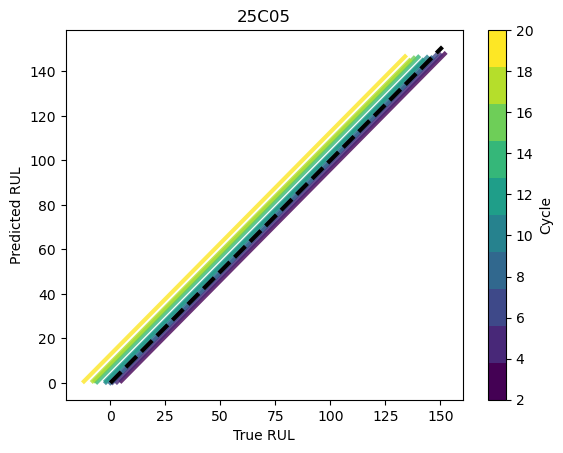

For Batterty 25C06 The Predicted RuL at Cycle 10 is: 100.60747208858712
The True RuL at Cycle 10 is: 112


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


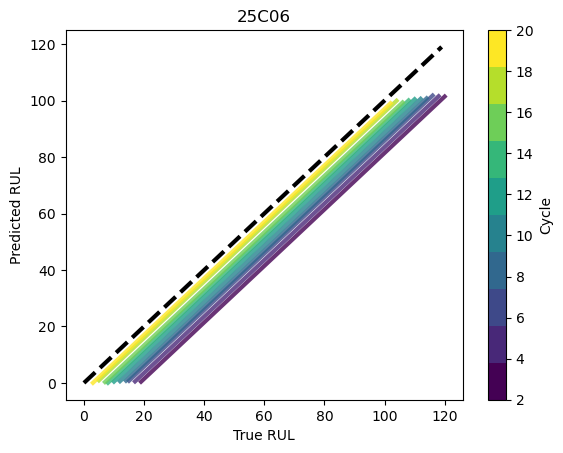

For Batterty 25C08 The Predicted RuL at Cycle 10 is: 65.89252657989293
The True RuL at Cycle 10 is: 24


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


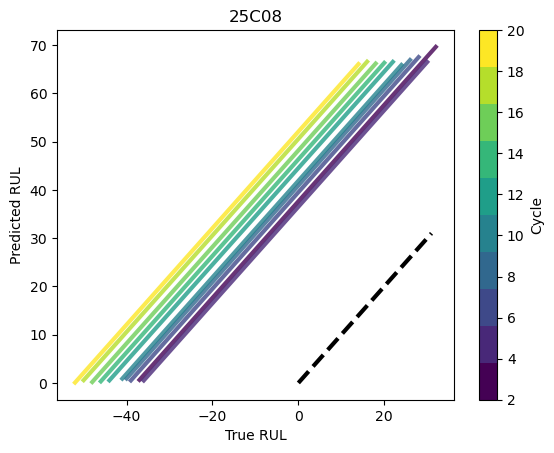

For Batterty 35C02 The Predicted RuL at Cycle 10 is: 265.13619291605175
The True RuL at Cycle 10 is: 254


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


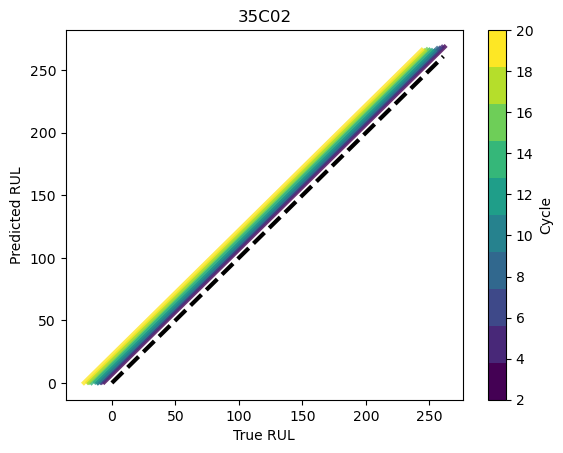

For Batterty 45C02 The Predicted RuL at Cycle 10 is: 376.4269232852294
The True RuL at Cycle 10 is: 380


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


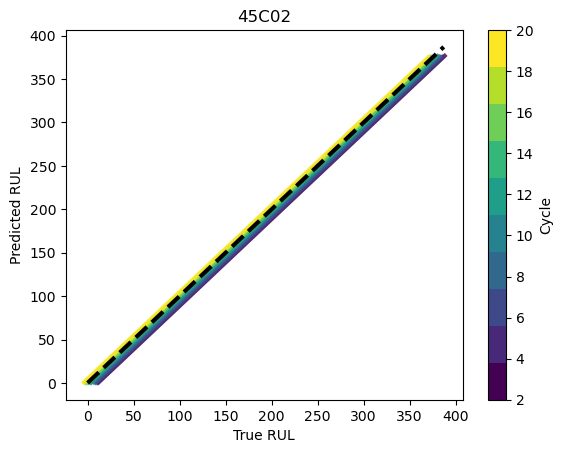

In [6]:
###
### First 20 cycles
### 20kHz and 8.8Hz
###
Train_Lst=['25C01','25C02','25C03','25C07','35C01','45C01']
Test_Lst=['25C05','25C06','25C08','35C02','45C02']
feats1=['20004.453 Im','8.81772 Im','temperature']
mydf=df_20

model = Lasso(alpha=0.05,random_state=42)
Trained_Model=Train_Regr_ML(mydf,Train_Lst,model,feats1)
print(Trained_Model.feature_names_in_)
print(Trained_Model.coef_)

all_Pred=np.array([])
all_True=np.array([])

for Label in Test_Lst:
    Pred,TruC=Test_Regr_Model(mydf,Label,Trained_Model,feats1)
    all_Pred=np.concatenate((all_Pred, Pred))
    all_True=np.concatenate((all_True, TruC))
    print('For Batterty',Label,'The Predicted RuL at Cycle 10 is:',Pred[4])
    print('The True RuL at Cycle 10 is:',TruC[4])
    make_Cycling_Plots(Pred,TruC,Label,save_info='III_20KHz_8Hz_Temp')
    



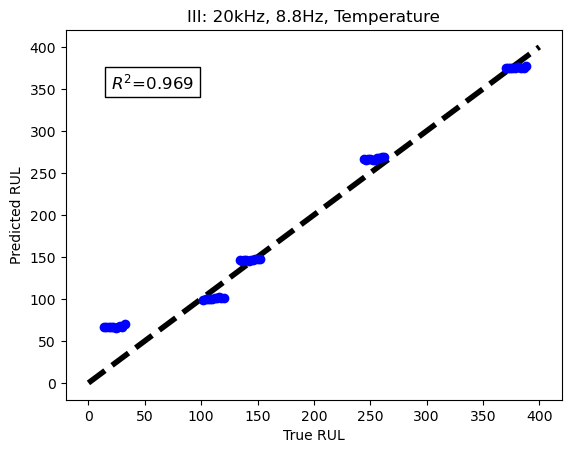

In [7]:
xref=np.linspace(0,400,400)
plt.plot(xref,xref,color='k',linestyle='dashed',linewidth=4,zorder=0)
plt.scatter(all_True,all_Pred,color='blue',zorder=1)
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('III: 20kHz, 8.8Hz, Temperature')
r2= r2_score(all_True,all_Pred)
R2string='$R^2$='+str(round(r2,3))
plt.text(20,350,R2string,fontsize='large',bbox=dict(facecolor='white'))
plt.savefig('./Figures/III_Regr_20k8HT.png',format='png',dpi=600)
plt.show()


['20004.453 Im' 'temperature']
[-2819.17684315    12.73670858]
For Batterty 25C05 The Predicted RuL at Cycle 10 is: 106.36720227465003
The True RuL at Cycle 10 is: 144


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


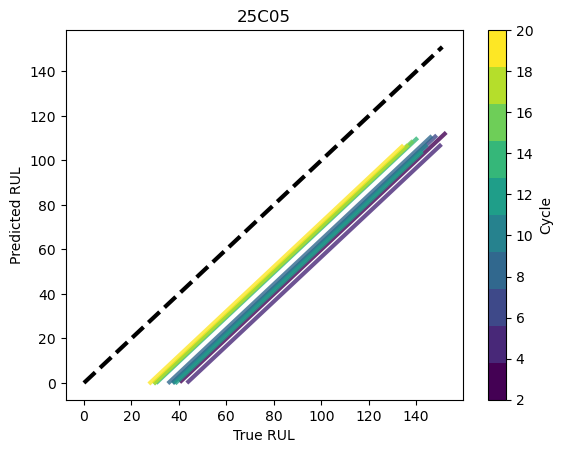

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


For Batterty 25C06 The Predicted RuL at Cycle 10 is: 80.14885763332745
The True RuL at Cycle 10 is: 112


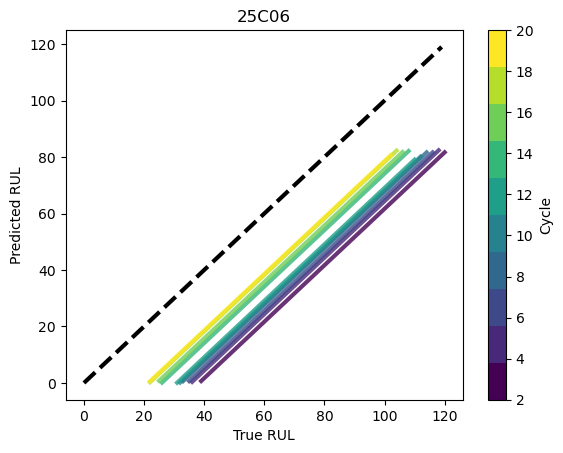

For Batterty 25C08 The Predicted RuL at Cycle 10 is: 75.41264053683045
The True RuL at Cycle 10 is: 24


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


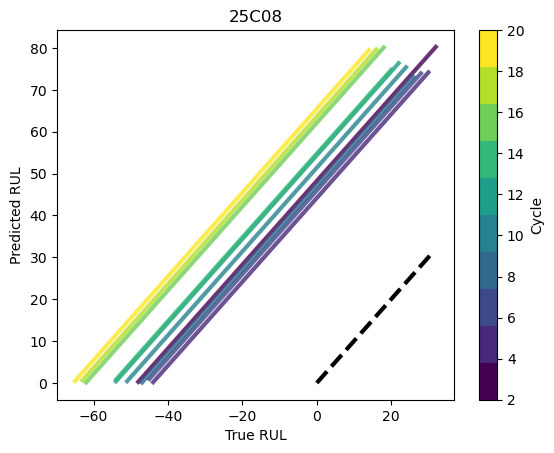

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


For Batterty 35C02 The Predicted RuL at Cycle 10 is: 232.18374082796942
The True RuL at Cycle 10 is: 254


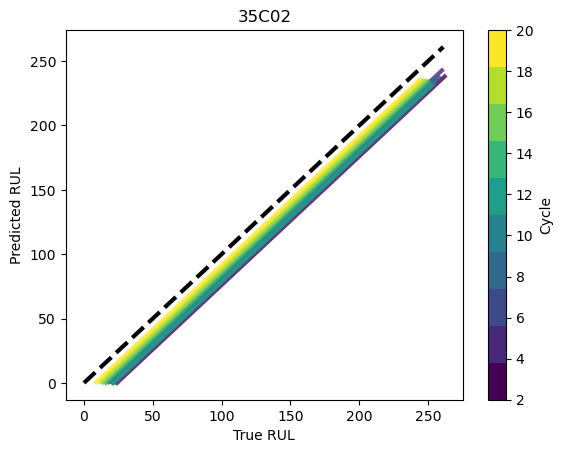

For Batterty 45C02 The Predicted RuL at Cycle 10 is: 387.8835539187102
The True RuL at Cycle 10 is: 380


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


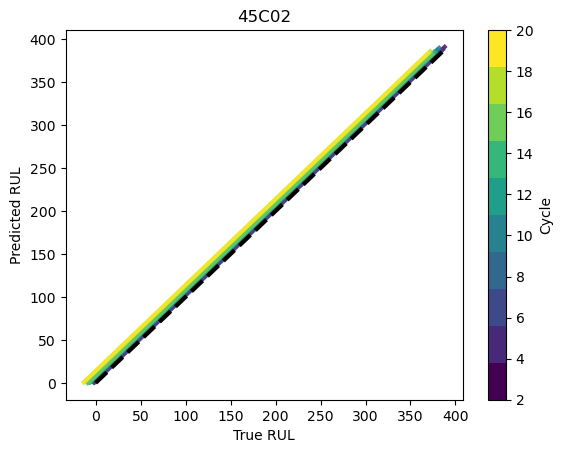

In [8]:
###
### First 20 cycles
### Only 20kHz
###
Train_Lst=['25C01','25C02','25C03','25C07','35C01','45C01']
Test_Lst=['25C05','25C06','25C08','35C02','45C02']
feats1=['20004.453 Im','temperature']
mydf=df_20

model = Lasso(alpha=0.1,random_state=42)
Trained_Model=Train_Regr_ML(mydf,Train_Lst,model,feats1)
print(Trained_Model.feature_names_in_)
print(Trained_Model.coef_)

all_Pred=np.array([])
all_True=np.array([])

for Label in Test_Lst:
    Pred,TruC=Test_Regr_Model(mydf,Label,Trained_Model,feats1)
    all_Pred=np.concatenate((all_Pred, Pred))
    all_True=np.concatenate((all_True, TruC))
    print('For Batterty',Label,'The Predicted RuL at Cycle 10 is:',Pred[4])
    print('The True RuL at Cycle 10 is:',TruC[4])
    make_Cycling_Plots(Pred,TruC,Label)
    


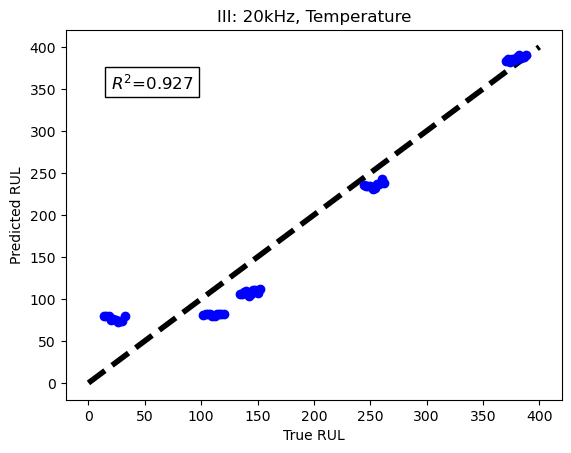

In [9]:
xref=np.linspace(0,400,400)
plt.plot(xref,xref,color='k',linestyle='dashed',linewidth=4,zorder=0)
plt.scatter(all_True,all_Pred,color='blue',zorder=1)
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('III: 20kHz, Temperature')
r2= r2_score(all_True,all_Pred)
R2string='$R^2$='+str(round(r2,3))
plt.text(20,350,R2string,fontsize='large',bbox=dict(facecolor='white'))
plt.savefig('./Figures/III_Regr_20kT.png',format='png',dpi=600)
plt.show()



['0.03192 Im' 'temperature']
[45.50308686 14.95266302]
For Batterty 25C05 The Predicted RuL at Cycle 10 is: 78.97637672366994
The True RuL at Cycle 10 is: 144


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


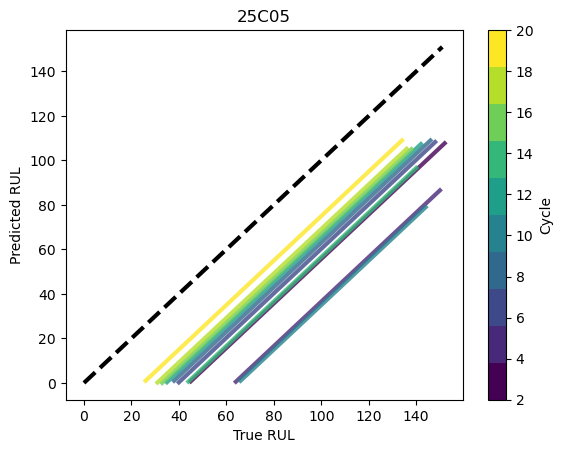

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


For Batterty 25C06 The Predicted RuL at Cycle 10 is: 106.14854503956673
The True RuL at Cycle 10 is: 112


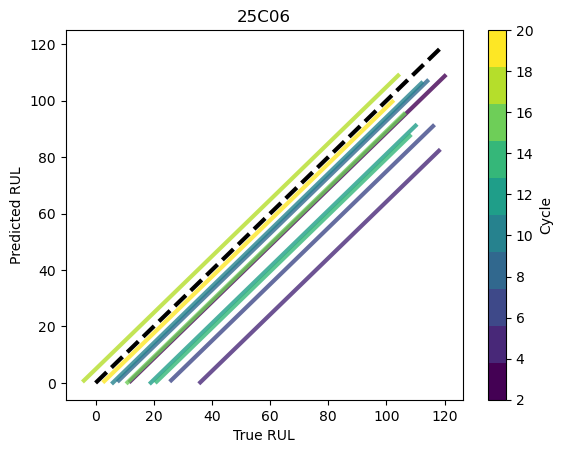

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


For Batterty 25C08 The Predicted RuL at Cycle 10 is: 109.26050114962982
The True RuL at Cycle 10 is: 24


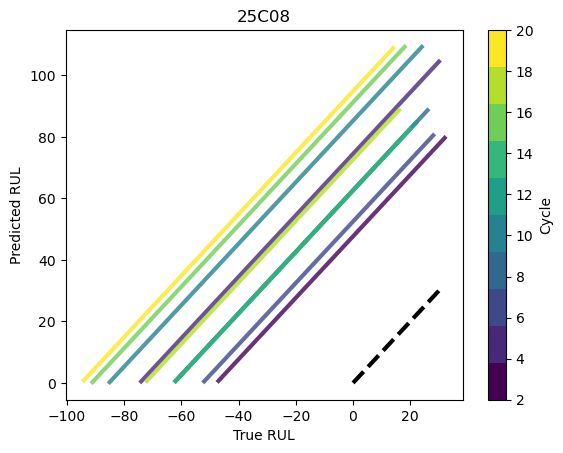

For Batterty 35C02 The Predicted RuL at Cycle 10 is: 248.79556357789528
The True RuL at Cycle 10 is: 254


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


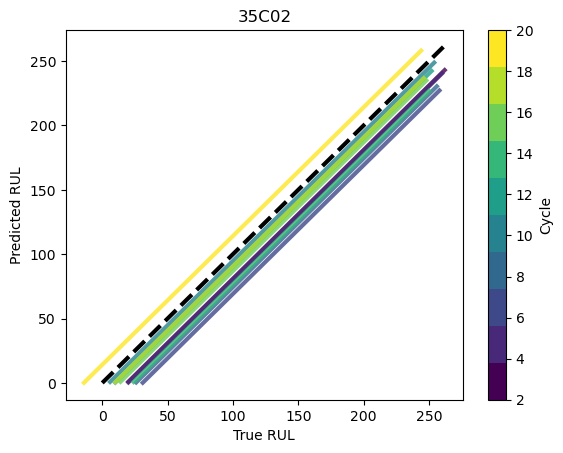

For Batterty 45C02 The Predicted RuL at Cycle 10 is: 378.188442976888
The True RuL at Cycle 10 is: 380


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


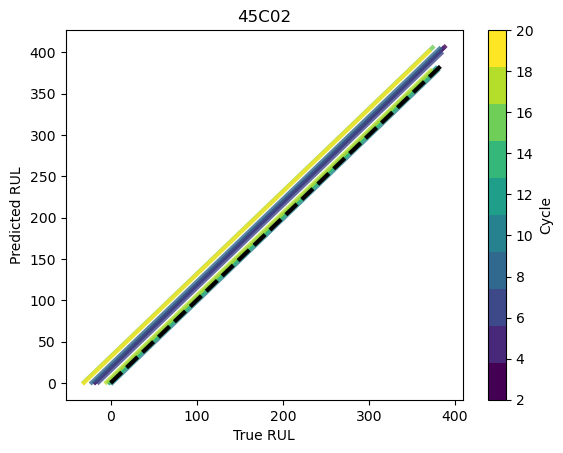

In [10]:
###
### First 20 cycles
### Only 0.03Hz
###
Train_Lst=['25C01','25C02','25C03','25C07','35C01','45C01']
Test_Lst=['25C05','25C06','25C08','35C02','45C02']
feats1=['0.03192 Im','temperature']
mydf=df_20

model = Lasso(alpha=0.1,random_state=42)
Trained_Model=Train_Regr_ML(mydf,Train_Lst,model,feats1)
print(Trained_Model.feature_names_in_)
print(Trained_Model.coef_)

all_Pred=np.array([])
all_True=np.array([])

for Label in Test_Lst:
    Pred,TruC=Test_Regr_Model(mydf,Label,Trained_Model,feats1)
    all_Pred=np.concatenate((all_Pred, Pred))
    all_True=np.concatenate((all_True, TruC))
    print('For Batterty',Label,'The Predicted RuL at Cycle 10 is:',Pred[4])
    print('The True RuL at Cycle 10 is:',TruC[4])
    make_Cycling_Plots(Pred,TruC,Label)

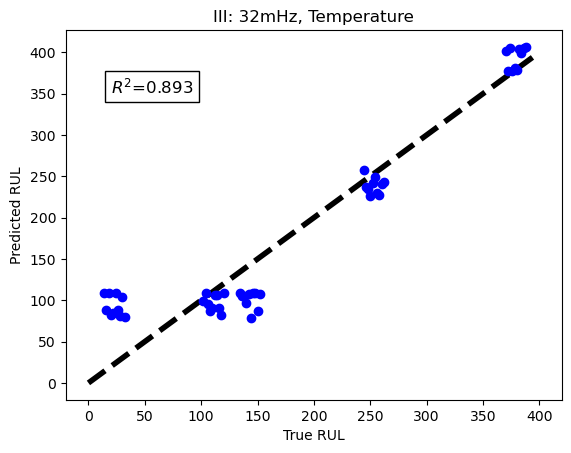

In [11]:
xref=np.linspace(0,400,400)
plt.plot(xref,xref,color='k',linestyle='dashed',linewidth=4,zorder=0)
plt.scatter(all_True,all_Pred,color='blue',zorder=1)
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('III: 32mHz, Temperature')
r2= r2_score(all_True,all_Pred)
R2string='$R^2$='+str(round(r2,3))
plt.text(20,350,R2string,fontsize='large',bbox=dict(facecolor='white'))
plt.savefig('./Figures/III_Regr_32mT.png',format='png',dpi=600)
plt.show()


['8.81772 Im' 'temperature']
[-455.21684312    9.42665156]
For Batterty 25C05 The Predicted RuL at Cycle 10 is: 147.12281993249007
The True RuL at Cycle 10 is: 144


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


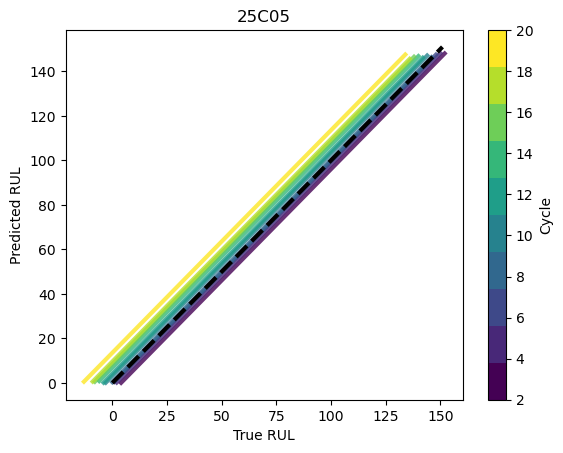

For Batterty 25C06 The Predicted RuL at Cycle 10 is: 102.91671229758506
The True RuL at Cycle 10 is: 112


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


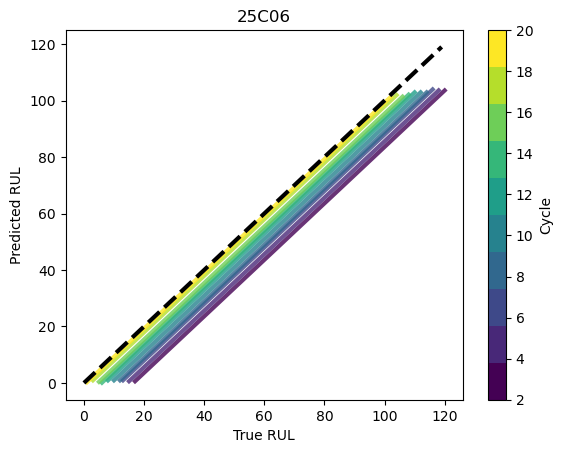

For Batterty 25C08 The Predicted RuL at Cycle 10 is: 67.40979853460914
The True RuL at Cycle 10 is: 24


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


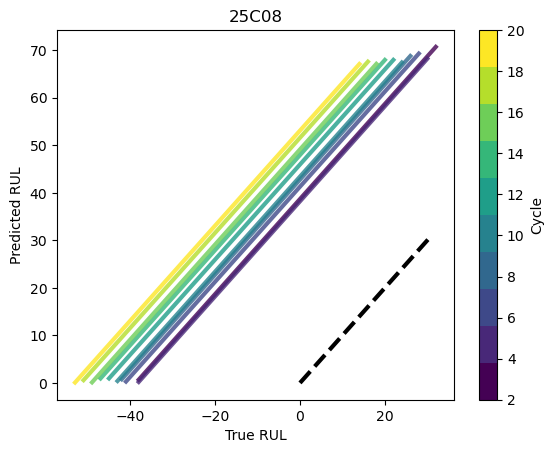

For Batterty 35C02 The Predicted RuL at Cycle 10 is: 267.36400862853435
The True RuL at Cycle 10 is: 254


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


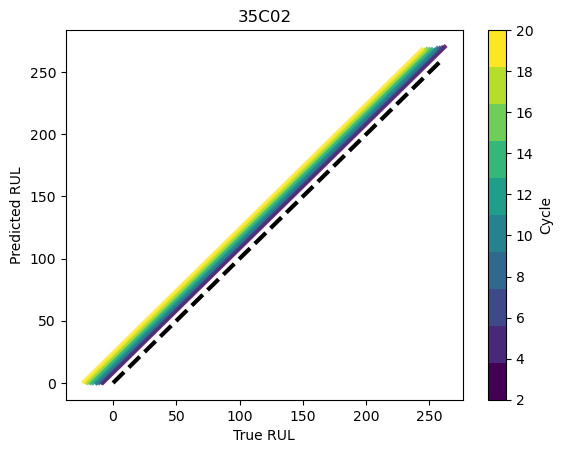

For Batterty 45C02 The Predicted RuL at Cycle 10 is: 375.97440698298846
The True RuL at Cycle 10 is: 380


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


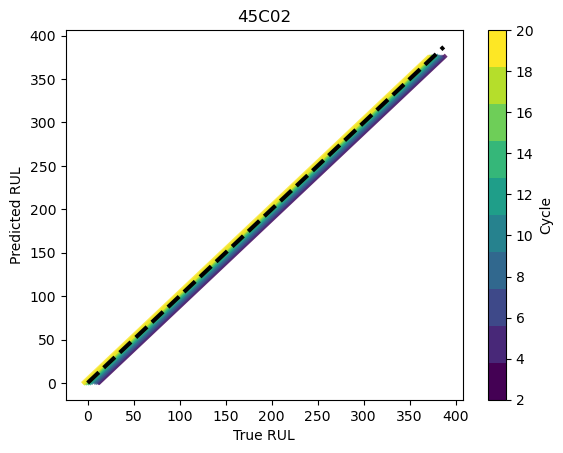

In [12]:
###
### First 20 cycles
### Only 8.8Hz
###
Train_Lst=['25C01','25C02','25C03','25C07','35C01','45C01']
Test_Lst=['25C05','25C06','25C08','35C02','45C02']
feats1=['8.81772 Im','temperature']
mydf=df_20

model = Lasso(alpha=0.1,random_state=42)
Trained_Model=Train_Regr_ML(mydf,Train_Lst,model,feats1)
print(Trained_Model.feature_names_in_)
print(Trained_Model.coef_)

all_Pred=np.array([])
all_True=np.array([])

for Label in Test_Lst:
    Pred,TruC=Test_Regr_Model(mydf,Label,Trained_Model,feats1)
    all_Pred=np.concatenate((all_Pred, Pred))
    all_True=np.concatenate((all_True, TruC))
    print('For Batterty',Label,'The Predicted RuL at Cycle 10 is:',Pred[4])
    print('The True RuL at Cycle 10 is:',TruC[4])
    make_Cycling_Plots(Pred,TruC,Label)

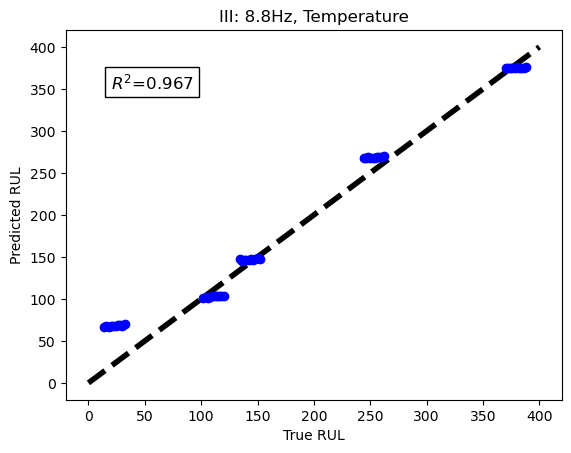

In [13]:
xref=np.linspace(0,400,400)
plt.plot(xref,xref,color='k',linestyle='dashed',linewidth=4,zorder=0)
plt.scatter(all_True,all_Pred,color='blue',zorder=1)
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('III: 8.8Hz, Temperature')
r2= r2_score(all_True,all_Pred)
R2string='$R^2$='+str(round(r2,3))
plt.text(20,350,R2string,fontsize='large',bbox=dict(facecolor='white'))
plt.savefig('./Figures/III_Regr_8HT.png',format='png',dpi=600)
plt.show()


['17.79613 Im' '2.16054 Im' 'temperature']
[-2077.37035429  1611.24337642     3.70489253]
For Batterty 25C05 The Predicted RuL at Cycle 10 is: 155.49941920468206
The True RuL at Cycle 10 is: 144


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


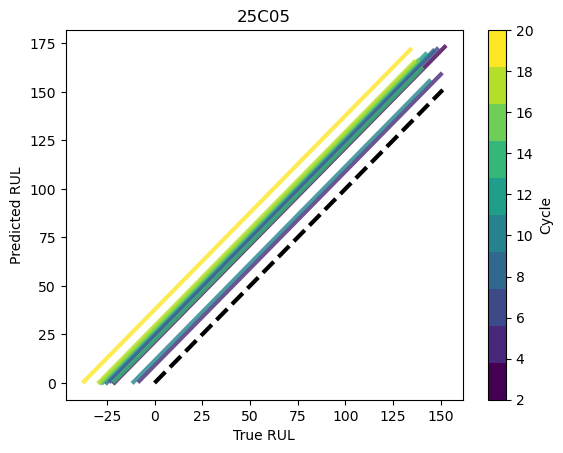

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


For Batterty 25C06 The Predicted RuL at Cycle 10 is: 55.81682717359149
The True RuL at Cycle 10 is: 112


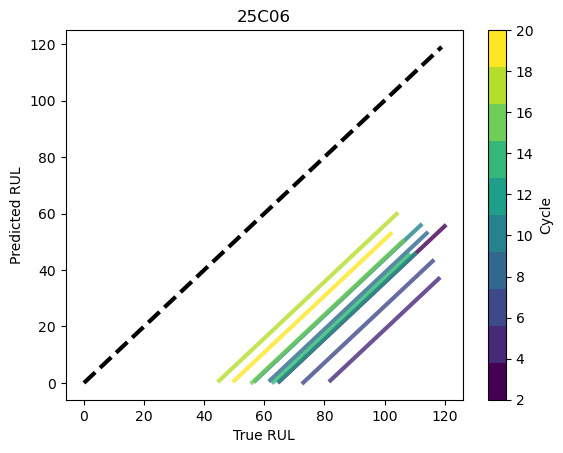

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


For Batterty 25C08 The Predicted RuL at Cycle 10 is: 129.44545577208595
The True RuL at Cycle 10 is: 24


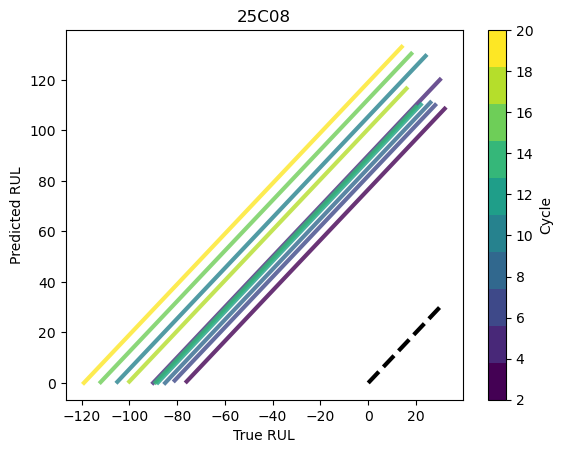

For Batterty 35C02 The Predicted RuL at Cycle 10 is: 287.5842283110695
The True RuL at Cycle 10 is: 254


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


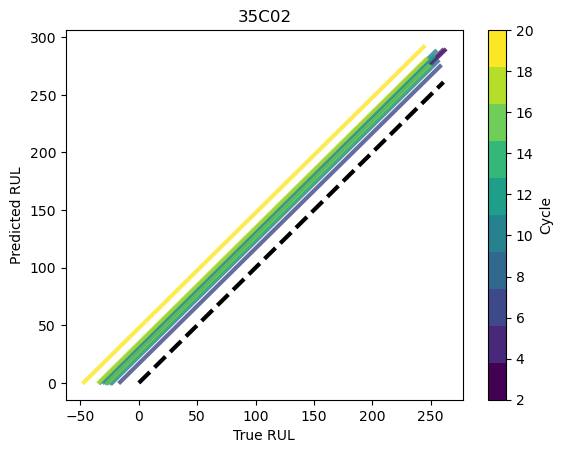

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


For Batterty 45C02 The Predicted RuL at Cycle 10 is: 366.7606332931567
The True RuL at Cycle 10 is: 380


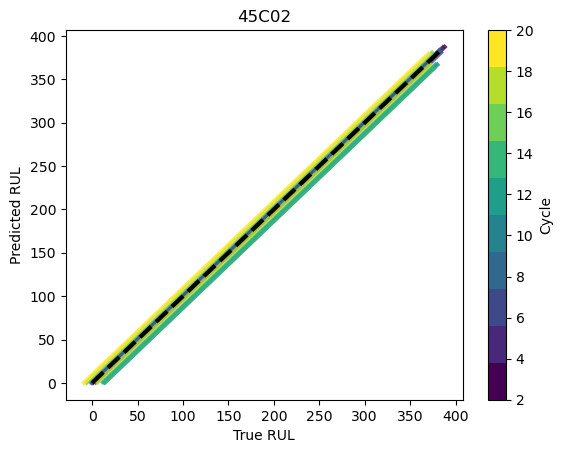

In [14]:
###
### First 20 cycles
### ARD frequencies from refernce paper plus temperature. 
###
Train_Lst=['25C01','25C02','25C03','25C07','35C01','45C01']
Test_Lst=['25C05','25C06','25C08','35C02','45C02']
feats1=['17.79613 Im','2.16054 Im','temperature']
mydf=df_20

model = Lasso(alpha=0.1,random_state=42)
Trained_Model=Train_Regr_ML(mydf,Train_Lst,model,feats1)
print(Trained_Model.feature_names_in_)
print(Trained_Model.coef_)

all_Pred=np.array([])
all_True=np.array([])

for Label in Test_Lst:
    Pred,TruC=Test_Regr_Model(mydf,Label,Trained_Model,feats1)
    all_Pred=np.concatenate((all_Pred, Pred))
    all_True=np.concatenate((all_True, TruC))
    print('For Batterty',Label,'The Predicted RuL at Cycle 10 is:',Pred[4])
    print('The True RuL at Cycle 10 is:',TruC[4])
    make_Cycling_Plots(Pred,TruC,Label)

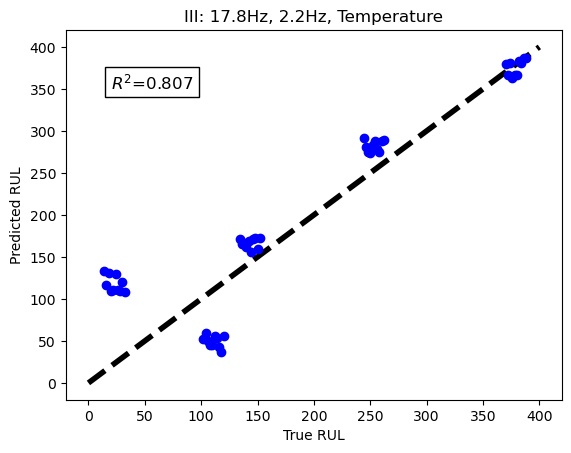

In [15]:
xref=np.linspace(0,400,400)
plt.plot(xref,xref,color='k',linestyle='dashed',linewidth=4,zorder=0)
plt.scatter(all_True,all_Pred,color='blue',zorder=1)
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('III: 17.8Hz, 2.2Hz, Temperature')
r2= r2_score(all_True,all_Pred)
R2string='$R^2$='+str(round(r2,3))
plt.text(20,350,R2string,fontsize='large',bbox=dict(facecolor='white'))
plt.savefig('./Figures/III_Regr_RefT.png',format='png',dpi=600)
plt.show()


/Users/christian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.141e+03, tolerance: 1.097e+02
  model = cd_fast.enet_coordinate_descent(
/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


['20004.453 Re' '15829.126 Re' '12516.703 Re' '9909.4424 Re' '7835.48 Re'
 '6217.2461 Re' '4905.291 Re' '3881.2737 Re' '3070.9827 Re' '2430.7778 Re'
 '1923.1537 Re' '1522.4358 Re' '1203.8446 Re' '952.86591 Re'
 '754.27557 Re' '596.71857 Re' '471.96338 Re' '373.20856 Re'
 '295.47278 Re' '233.87738 Re' '185.05922 Re' '146.35823 Re'
 '115.77804 Re' '91.6721 Re' '72.51701 Re' '57.36816 Re' '45.3629 Re'
 '35.93134 Re' '28.40909 Re' '22.48202 Re' '17.79613 Re' '14.06813 Re'
 '11.1448 Re' '8.81772 Re' '6.97545 Re' '5.5173 Re' '4.36941 Re'
 '3.45686 Re' '2.73547 Re' '2.16054 Re' '1.70952 Re' '1.35352 Re'
 '1.07079 Re' '0.84734 Re' '0.67072 Re' '0.53067 Re' '0.41976 Re'
 '0.33183 Re' '0.26261 Re' '0.20791 Re' '0.16452 Re' '0.13007 Re'
 '0.10309 Re' '0.08153 Re' '0.06443 Re' '0.05102 Re' '0.04042 Re'
 '0.03192 Re' '0.02528 Re' '0.01999 Re' '20004.453 Im' '15829.126 Im'
 '12516.703 Im' '9909.4424 Im' '7835.48 Im' '6217.2461 Im' '4905.291 Im'
 '3881.2737 Im' '3070.9827 Im' '2430.7778 Im' '1923.153

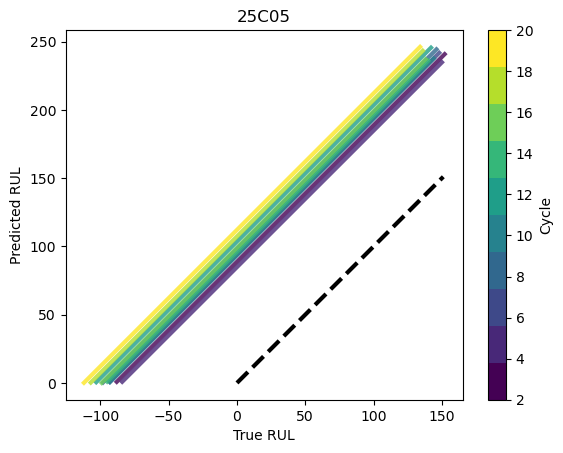

For Batterty 25C06 The Predicted RuL at Cycle 10 is: 33.551134739100235
The True RuL at Cycle 10 is: 112


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


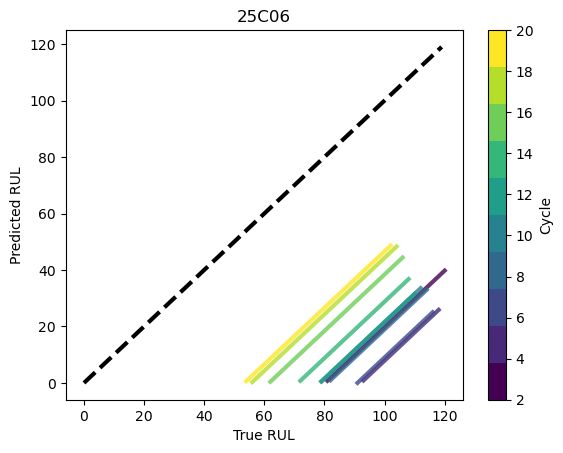

For Batterty 25C08 The Predicted RuL at Cycle 10 is: 133.74290788451538
The True RuL at Cycle 10 is: 24


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


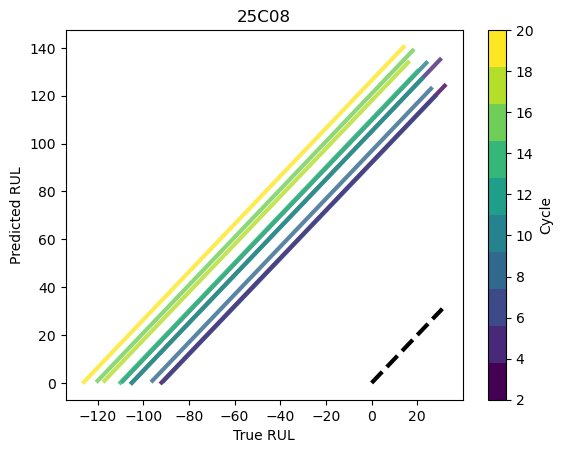

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


For Batterty 35C02 The Predicted RuL at Cycle 10 is: 244.55748560199663
The True RuL at Cycle 10 is: 254


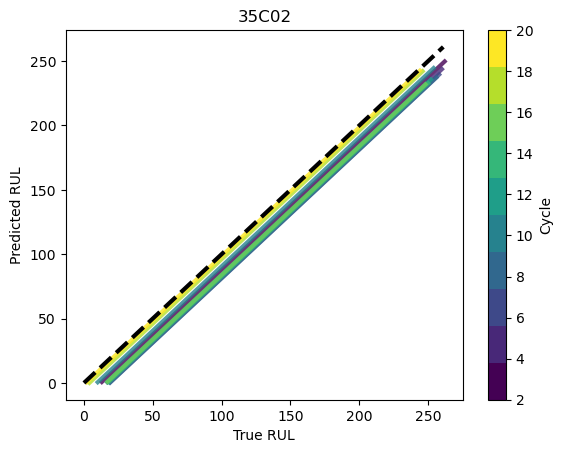

For Batterty 45C02 The Predicted RuL at Cycle 10 is: 244.04977023565812
The True RuL at Cycle 10 is: 380


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


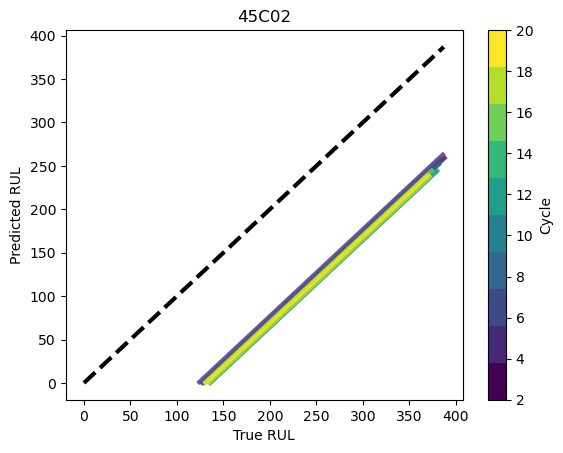

In [16]:
###
### All EIS
###
Train_Lst=['25C01','25C02','25C03','25C07','35C01','45C01']
Test_Lst=['25C05','25C06','25C08','35C02','45C02']
feats1=df_20.columns.to_list()[5:125]+['temperature']
mydf=df_20

model = Lasso(alpha=0.2,random_state=42)
Trained_Model=Train_Regr_ML(mydf,Train_Lst,model,feats1)
print(Trained_Model.feature_names_in_)
print(Trained_Model.coef_)

all_Pred=np.array([])
all_True=np.array([])

for Label in Test_Lst:
    Pred,TruC=Test_Regr_Model(mydf,Label,Trained_Model,feats1)
    all_Pred=np.concatenate((all_Pred, Pred))
    all_True=np.concatenate((all_True, TruC))
    print('For Batterty',Label,'The Predicted RuL at Cycle 10 is:',Pred[4])
    print('The True RuL at Cycle 10 is:',TruC[4])
    make_Cycling_Plots(Pred,TruC,Label)

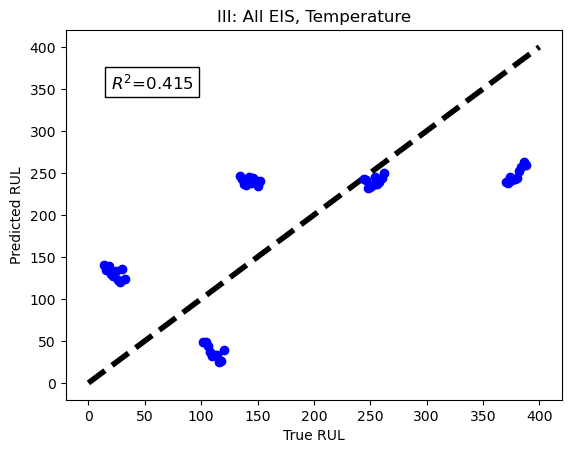

In [17]:
xref=np.linspace(0,400,400)
plt.plot(xref,xref,color='k',linestyle='dashed',linewidth=4,zorder=0)
plt.scatter(all_True,all_Pred,color='blue',zorder=1)
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('III: All EIS, Temperature')
r2= r2_score(all_True,all_Pred)
R2string='$R^2$='+str(round(r2,3))
plt.text(20,350,R2string,fontsize='large',bbox=dict(facecolor='white'))
plt.savefig('./Figures/III_Regr_All.png',format='png',dpi=600)
plt.show()


['EIS_PCA_1' 'EIS_PCA_2' 'temperature']
[-22.60275322  79.69378514  -0.53145642]
For Batterty 25C05 The Predicted RuL at Cycle 10 is: 197.7827827589879
The True RuL at Cycle 10 is: 144


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


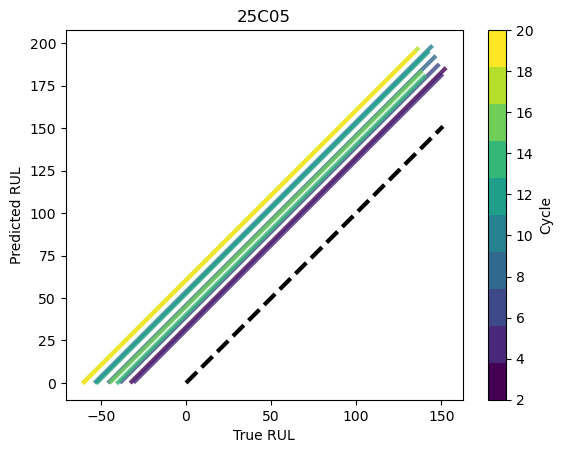

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


For Batterty 25C06 The Predicted RuL at Cycle 10 is: 102.75300229838793
The True RuL at Cycle 10 is: 112


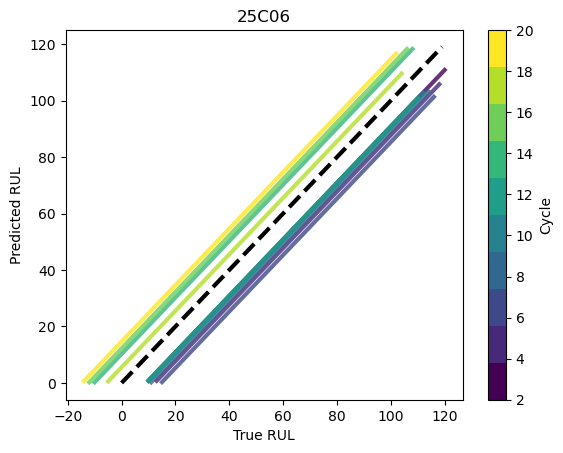

For Batterty 25C08 The Predicted RuL at Cycle 10 is: 63.918914129684865
The True RuL at Cycle 10 is: 24


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


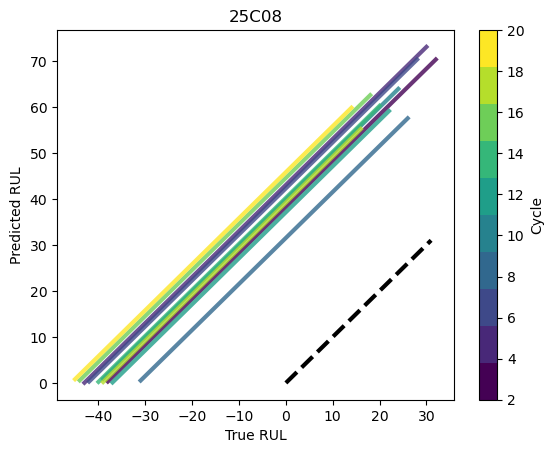

For Batterty 35C02 The Predicted RuL at Cycle 10 is: 249.29886630710251
The True RuL at Cycle 10 is: 254


/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


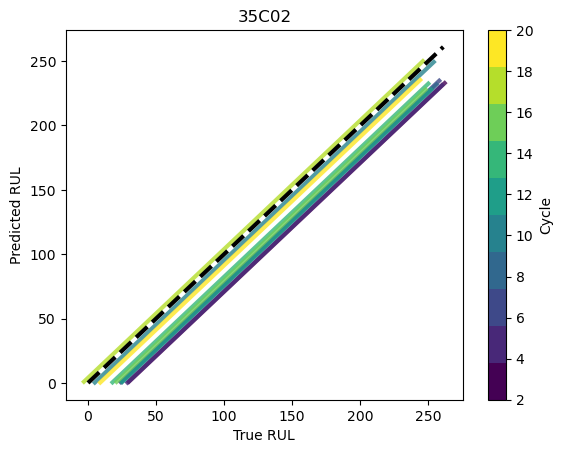

/var/folders/sj/6rybm12j2n9b9m1yvtw0335r0000gn/T/ipykernel_27282/1643362567.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=plt.colorbar(sm,ticks=np.linspace(2,2*len(TotalP),N))


For Batterty 45C02 The Predicted RuL at Cycle 10 is: 260.47722988668534
The True RuL at Cycle 10 is: 380


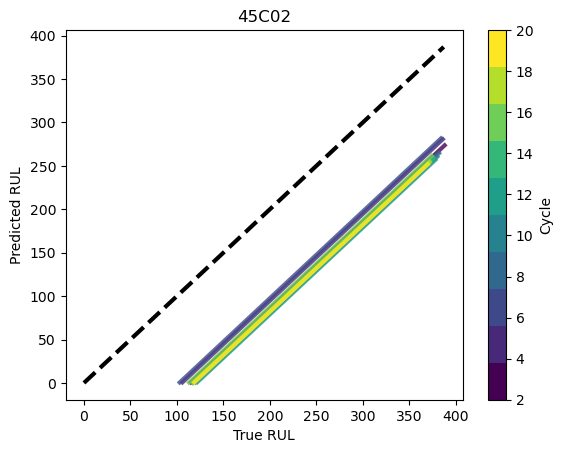

In [18]:
###
### PCA
###
Train_Lst=['25C01','25C02','25C03','25C07','35C01','45C01']
Test_Lst=['25C05','25C06','25C08','35C02','45C02']
feats1=['EIS_PCA_1','EIS_PCA_2','temperature']
mydf=df_20

model = Lasso(alpha=0.2,random_state=42)
Trained_Model=Train_Regr_ML(mydf,Train_Lst,model,feats1)
print(Trained_Model.feature_names_in_)
print(Trained_Model.coef_)

all_Pred=np.array([])
all_True=np.array([])

for Label in Test_Lst:
    Pred,TruC=Test_Regr_Model(mydf,Label,Trained_Model,feats1)
    all_Pred=np.concatenate((all_Pred, Pred))
    all_True=np.concatenate((all_True, TruC))
    print('For Batterty',Label,'The Predicted RuL at Cycle 10 is:',Pred[4])
    print('The True RuL at Cycle 10 is:',TruC[4])
    make_Cycling_Plots(Pred,TruC,Label)

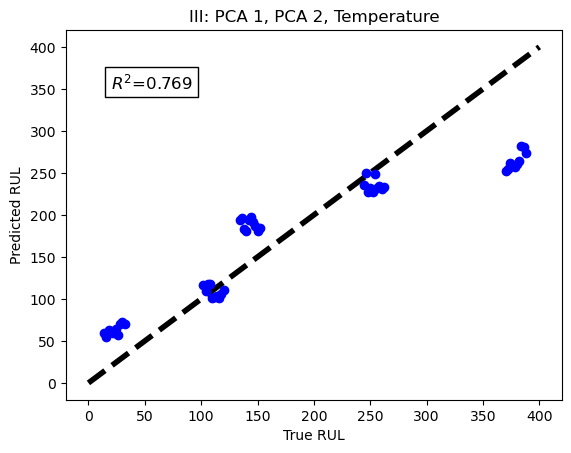

In [19]:
xref=np.linspace(0,400,400)
plt.plot(xref,xref,color='k',linestyle='dashed',linewidth=4,zorder=0)
plt.scatter(all_True,all_Pred,color='blue',zorder=1)
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('III: PCA 1, PCA 2, Temperature')
r2= r2_score(all_True,all_Pred)
R2string='$R^2$='+str(round(r2,3))
plt.text(20,350,R2string,fontsize='large',bbox=dict(facecolor='white'))
plt.savefig('./Figures/III_Regr_PCA.png',format='png',dpi=600)
plt.show()
